# Simulation for dynamic BEMB
This notebook simulates dataset to test performances of dynamic embedding models for the student proficiencies.

Author: Tianyu Du

Date: May. 11, 2022

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

plt.style.use(['science', 'no-latex'])

# Configure the Size of the Simulation

**Important Notation**: we use $u$ (stands for user) to denote student and $i$ (stands for item) to denote question.

In [93]:
NUM_STUDENTS = 100
NUM_MATH_QUESTIONS = 500
NUM_ENGLISH_QUESTIONS = 500
NUM_QUESTIONS = NUM_MATH_QUESTIONS + NUM_ENGLISH_QUESTIONS
AVG_QUESTION_PER_DAY = 5
TOTAL_DAYS = 7

# Generate Students' Initial Proficiencies $\theta_u^0$
The student (indexed by $u$) latents $\theta_u$ represents the **student proficiencies** here.

$$
\theta_u^0 \overset{i.i.d.}{\sim} \text{Unif}([0, 1]^2)
$$

For this simulation, we assume student and question latents are living in $\mathbb{R}^2$. Further, we assume the x-axis measures `language skills` and the y-axis measures `math skills` (so the latent is not *really* latent).

Students' initial proficiencies are generated by a uniform distribution.

In [6]:
theta_0 = torch.rand(NUM_STUDENTS, 2)

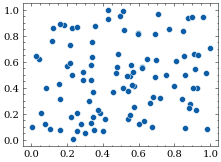

In [17]:
sns.scatterplot(x=theta_0.numpy().T[0], y=theta_0.numpy().T[1])
plt.show()

# Generate Questions' Difficulties $\beta_i$

We assume questions (indexed by $i$) fall into two categories: English and Math. The latent $\beta_i$ represents the **difficulty** of the question.
For example, for a student with high proficiency in English, the inner product of $\theta_u^t$ and $\beta_i$ should be high for English questions.

Difficulties of English questions are generated following 

$$
\beta_i^{English} \overset{i.i.d.}{\sim} \mathcal{N}([0.7, 0.1], 0.1I)
$$

so that they require a high proficiency in English (i.e., the x-axis).

Difficulties of Math questions are generated following

$$
\beta_i^{Math} \overset{i.i.d.}{\sim} \mathcal{N}([0.1, 0.7], 0.1I)
$$

In [18]:
mu_english = torch.Tensor([[0.7, 0.1]])
mu_math = torch.Tensor([[0.1, 0.7]])

In [44]:
beta_english = torch.randn(NUM_ENGLISH_QUESTIONS, 2) * 0.1 + mu_english
beta_math = torch.randn(NUM_MATH_QUESTIONS, 2) * 0.1 + mu_math
beta = torch.cat([beta_english, beta_math], dim=0)

The following figure shows the distribution of difficulties of questions and proficiencies of students.

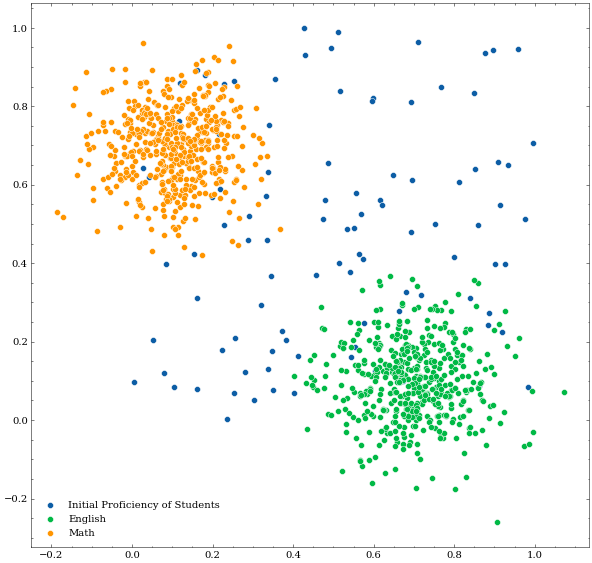

In [106]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=theta_0.numpy().T[0], y=theta_0.numpy().T[1], ax=ax, label='Initial Proficiency of Students')
sns.scatterplot(x=beta_english.numpy().T[0], y=beta_english.numpy().T[1], ax=ax, label='English')
sns.scatterplot(x=beta_math.numpy().T[0], y=beta_math.numpy().T[1], ax=ax, label='Math')
ax.legend()
plt.show()

# Generate Student-Question Response
Now we generate the actual dataset of students-questions-responses (i.e., either they answered correctly or incorrectly).

Specifically, for each time $t$ and each student $u$,
* We assume the student $u$ attempts $K \sim Poisson(\lambda)$ questions, where $\lambda$ is controlled by `AVG_QUESTION_PER_DAY`. Let $\mathcal{Q}$ denote the set of questions that the student $u$ attempted, $\mathcal{Q}$ is different for different students.
* We randomly sample $K$ questions from the pool of questions and the student $u$ answers these questions.
* The probability for student $u$ to answer question $i$ correctly is
  
$$
\frac{1}{1 + \exp^{-\theta_u^t \cdot \beta_i}}
$$

* The student's proficiency is updated according to the following rule so that students are learning from attempting these questions:
$$
    \theta_u^{t+1} = \theta_u^t + \alpha \frac{1}{K} \sum_{i \in \mathcal{Q}} \beta_i
$$
where the learning rate $\alpha \sim \text{Unif}([0.01, 0.02])$.

In [104]:
record = list()
true_theta_list = [theta_0]
# ALPHA = 0.01

for t in range(TOTAL_DAYS):
    # Generate # of questions each student tried this day.
    K_list = torch.poisson(torch.Tensor([AVG_QUESTION_PER_DAY] * NUM_STUDENTS))

    new_theta_all_students = list()
    
    for u in range(NUM_STUDENTS):
        K = int(K_list[u])
        if K > 0:
            I_list = torch.randperm(NUM_QUESTIONS)[:K]
            theta_ut = true_theta_list[-1][u].view(2, 1)
            beta_answered = beta[I_list, :]  # (K, 2)
            p = (beta_answered @ theta_ut).squeeze(dim=1)  # (K, )
            response = torch.bernoulli(torch.sigmoid(p))  # (K, )

            ALPHA = np.random.rand() * 0.01 + 0.01
            learned = beta_answered.mean(dim=0) * ALPHA  # (2, )
            new_theta = theta_ut.view(2, ) + learned
            new_theta_all_students.append(new_theta)
        else:
            new_theta_all_students.append(true_theta_list[-1][u])
    
    new_theta = torch.stack(new_theta_all_students, dim=0)
    true_theta_list.append(new_theta)

The figure below demonstrates the behavior of dynamic proficiencies of students in 10 time periods, we can see that $\theta$'s are drifting to the top-right corner.

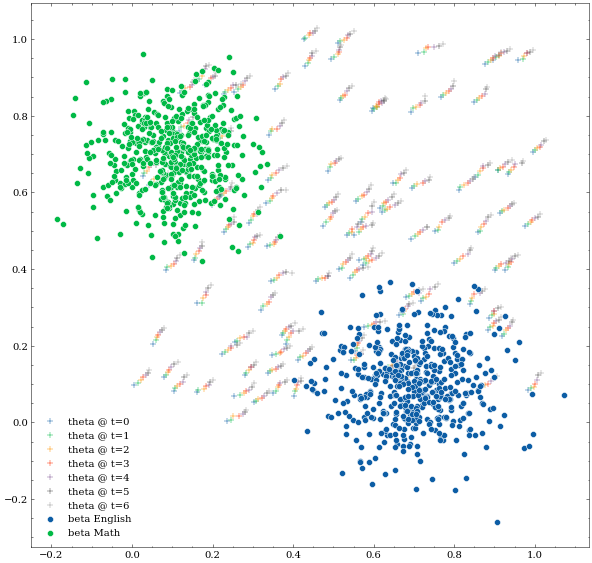

In [105]:
fig, ax = plt.subplots(figsize=(10, 10))
for t in range(TOTAL_DAYS):
    sns.scatterplot(x=true_theta_list[t].numpy().T[0], y=true_theta_list[t].numpy().T[1], ax=ax, label=f'theta @ t={t}', marker='+')
sns.scatterplot(x=beta_english.numpy().T[0], y=beta_english.numpy().T[1], ax=ax, label='beta English')
sns.scatterplot(x=beta_math.numpy().T[0], y=beta_math.numpy().T[1], ax=ax, label='beta Math')
ax.legend()
plt.show()